# Human hematopoiesis - data preprocessing

Here, we process a [human hematopoiesis dataset](https://doi.org/10.1038/s41587-023-01716-9) to infer the underlying
dynamics with CellRank in further analyses. This workflow includes the standard preprocessing steps of scRNA-seq data,
and the inference of a pseudotime with [Palantir](https://doi.org/10.1038/s41587-019-0068-4).

The corresponding data can be downloaded from [here](https://figshare.com/ndownloader/files/53393684) and should be
saved in `data/bone_marrow/raw/adata.h5ad`, _i.e._,

```bash
mkdir -p ../../data/bone_marrow/raw/
wget https://figshare.com/ndownloader/files/53393684 -O ../../data/bone_marrow/raw/adata.h5ad
```

## Library imports

In [1]:
import warnings

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplscience

import anndata as ad
import palantir
import scanpy as sc
import scvelo as scv

from crp import DATA_DIR, FIG_DIR

## General settings

In [2]:
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [3]:
sc.settings.verbosity = 2
scv.settings.verbosity = 3

In [4]:
mpl.use("module://matplotlib_inline.backend_inline")
mpl.rcParams["backend"]

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

In [5]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

## Constants

In [6]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / "pseudotimekernel").mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "svg"

In [ ]:
SAVE_RESULTS = False
if SAVE_RESULTS:
    (DATA_DIR / "bone_marrow" / "processed").mkdir(parents=True, exist_ok=True)

## Data loading

In [8]:
adata = ad.io.read_h5ad(DATA_DIR / "bone_marrow" / "raw" / "adata.h5ad")
adata

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype'
    var: 'highly_variable'
    uns: 'celltype_colors'
    obsm: 'X_umap'

## Data preprocessing

In [9]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, subset=True)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)


In [10]:
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_pcs=50, n_neighbors=30)

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)


In [11]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:06)


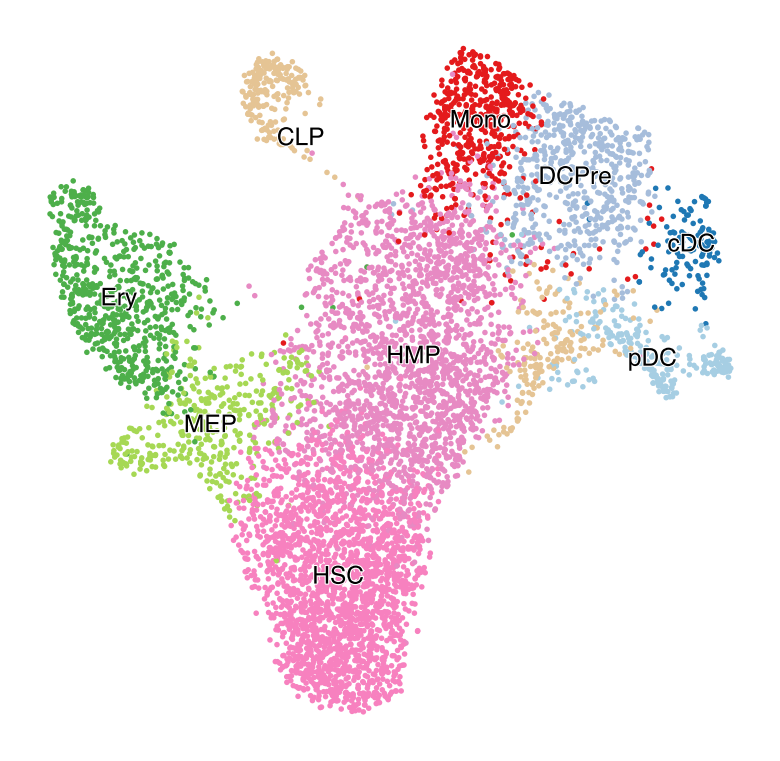

In [12]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 6))
    scv.pl.scatter(adata, basis="umap", color=["celltype"], size=25, dpi=100, title="", ax=ax)
    plt.show()

if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6, 6))
    scv.pl.scatter(adata, basis="umap", color=["celltype"], size=25, dpi=100, title="", legend_loc=False, ax=ax)
    fig.savefig(
        FIG_DIR / "pseudotimekernel" / "umap_colored_by_cell_type.png",
        dpi=400,
        transparent=True,
        bbox_inches="tight",
    )

In [13]:
pc_projection = pd.DataFrame(adata.obsm["X_pca"].copy(), index=adata.obs_names)

In [14]:
# diffusion maps
diff_maps = palantir.utils.run_diffusion_maps(pc_projection, n_components=15)

computing neighbors
    finished (0:00:00)


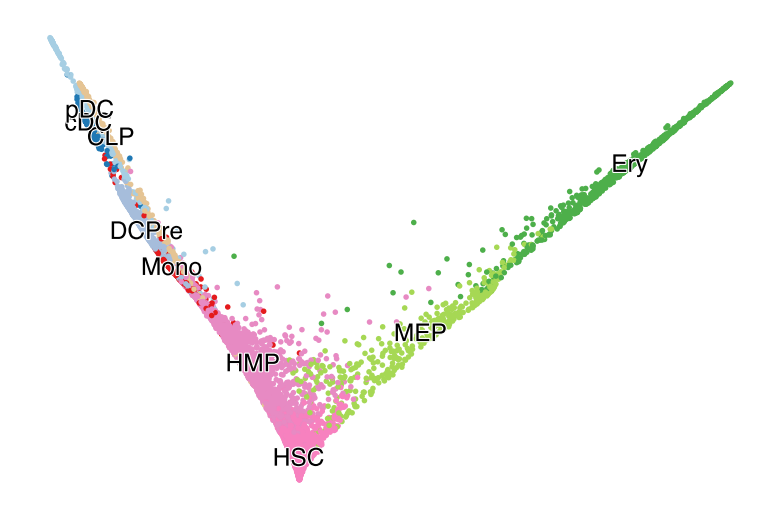

In [15]:
adata.obsm["X_diffmap"] = diff_maps["EigenVectors"].values.copy()
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="diffmap", color=["celltype"], components=["1, 2"], size=25, dpi=100, title="", ax=ax)
    plt.show()

In [16]:
# multiscale space
multiscale_space = palantir.utils.determine_multiscale_space(diff_maps)

In [17]:
magic_imputed = palantir.utils.run_magic_imputation(adata, diff_maps)

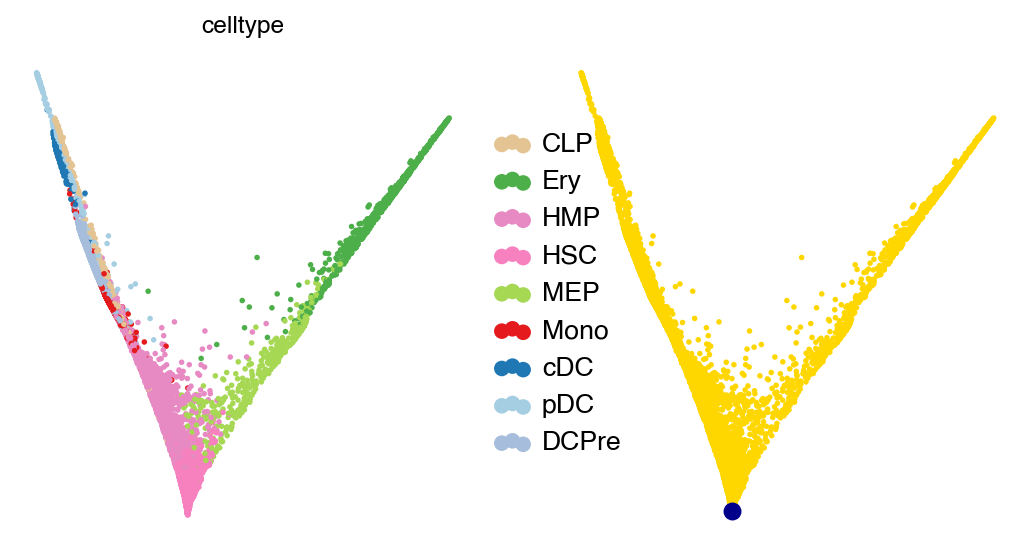

In [18]:
root_idx = 3290  # adata.obsm["X_diffmap"][:, 2].argmin()
with mplscience.style_context():
    scv.pl.scatter(adata, basis="diffmap", color=["celltype", root_idx], legend_loc="right", components="1, 2", size=25)
    plt.show()

In [19]:
palantir_res = palantir.core.run_palantir(
    multiscale_space, adata.obs_names[root_idx], use_early_cell_as_start=True, num_waypoints=500
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0016420483589172363 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.17764938672383626 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9995
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


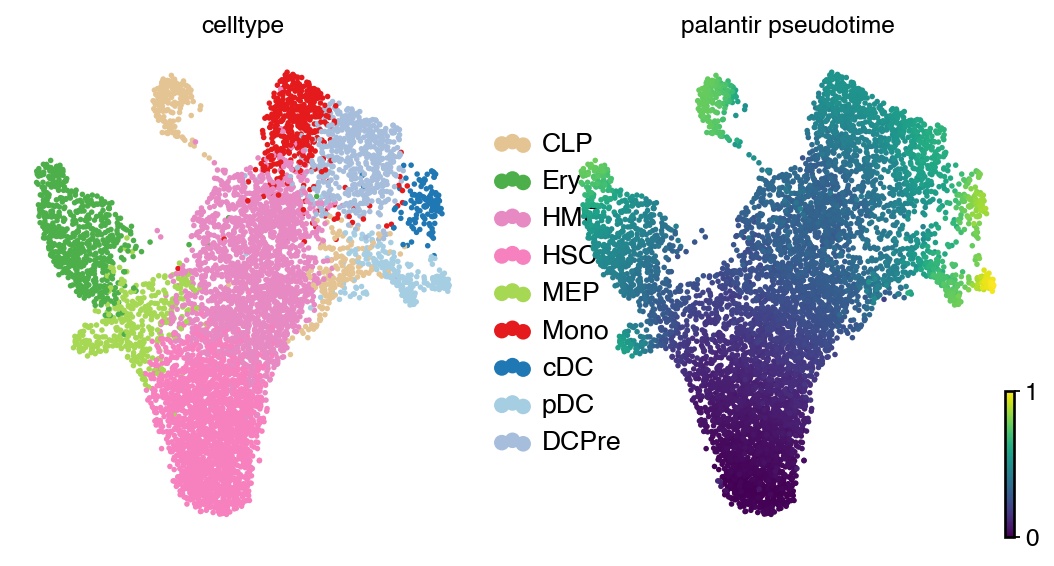

In [20]:
adata.obs["palantir_pseudotime"] = palantir_res.pseudotime

with mplscience.style_context():
    scv.pl.scatter(
        adata, basis="umap", color=["celltype", "palantir_pseudotime"], legend_loc="right", color_map="viridis", size=25
    )
    plt.show()

In [21]:
if SAVE_RESULTS:
    adata.write_h5ad(DATA_DIR / "bone_marrow" / "processed" / "adata.h5ad")